#Comparing Shallow and Deep Models for Dialects Identification

Identifying the language in which a document is written is a classic NLP task. While machine learning models reach near-perfect accuracy when classifying documents written in high-resource languages ([McNamee 2005](https://dl.acm.org/doi/abs/10.5555/1040196.1040208)), they struggle when discriminating among language varieties and dialects which are very similar to one another in low-resource settings, where labeled data is scarce ([Jauhiainen et al. 2019](https://www.jair.org/index.php/jair/article/view/11675)). 

Every year, the Workshop on NLP for Similar languages, Varieties and Dialects (VarDial) organizes several shared tasks that involve the categorization of texts belonging to similar languages.

Here I compare the performance of shallow and deep models on the Romanian Dialect Identification task ([Găman et al. 2020](https://aclanthology.org/2020.vardial-1.1.pdf)). 

##1. Romanian Dialect Identification task

<center><img src="http://www.serioustraveler.com/Web%20images/RomaniaMoldovaMap.jpg" width='500' height='300' align="center"/></center>


Moldavian is a dialect of Romanian which exhibits almost no difference with standard Romanian. The distinction between standard Romanian and Moldavian is only motivated by the presence of a political boundary, which corresponds to no real isogloss. In spelling, the two languages are almost identical, with a minor exception involving the distribution of the letters 'â' and 'î', although other grammatical distinctions can be found in number, gender and case morphology, and in lexical choices. 

The Romanian Dialect Identification task asks participants to classify Moldavian and Romanian texts from news articles ([Zampieri et al. 2019](https://wlv.openrepository.com/bitstream/handle/2436/622384/W19-1401.pdf?sequence=2&isAllowed=n)) and tweets ([Găman et al. 2020](https://aclanthology.org/2020.vardial-1.1.pdf), [Chakravarthi et al. 2021](https://helda.helsinki.fi/bitstream/handle/10138/329644/Findings2021.vardial_1.1.pdf?sequence=1)) using the MOROCO corpus ([Butnaru and Ionescu 2019](https://arxiv.org/pdf/1901.06543.pdf)). 

##2. Setting up the directory and loading the Tweet corpus 

I assembled the whole MOROCO-Tweets ([Găman and Ionescu 2021](https://onlinelibrary.wiley.com/doi/pdf/10.1002/int.22746?casa_token=UWWlygMpOWAAAAAA:Z605HEQQIPuUIU63o66Ll0vd6JbysOIaLSlCsLB6bTCO2a0Mf-0Kb2RI4cx8fc7Ct4evQczogXxk5g)) corpus (including both the validation and test files that you find in the associated [GitHub directory](https://github.com/raduionescu/MOROCO-Tweets)) in a unique file. Before training the classifiers, I access the directory where the file is stored. 

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/RMI-VarDial2021


/content/drive/My Drive/Colab Notebooks/RMI-VarDial2021


Here I load the dataset and perform preprocessing.

In [3]:
import string

categories, sentences = [], []

# Load the tweets development data and preprocess
for line in open('data/moroco-tweets.txt', encoding='utf-8', errors='ignore'):
    sentence, category = line.split('\t')
    category = category.strip()
    sentence = sentence.replace('$NE$','').replace('FOTO','').replace('VIDEO','').replace('LIVE','')
    sentence = sentence.translate(sentence.maketrans('', '', string.punctuation+'|-0123456789”„…\n\t'))
    categories.append(category)
    sentences.append(sentence.lower())

label_list = list(set(categories))

print("Number of Tweets: %s" %len(sentences))

Number of Tweets: 5237


The dataset contains 5237 tweets. Here is a sample of them. 

In [4]:
for label, tweet in zip(categories[:10], sentences[:10]):
  print(label, tweet)

RO premierul îi ia apărarea ministrului  nu e în conflict de interese 
RO preşedintele îccj    pensiilor  este tristă şi stupefiantă 
RO  februarie  ziua cu cele mai puţine aniversări doar  de români își serbează ziua de naștere o dată la pat
MD o bătrână din  a căzut de la etajul trei pe acoperișul unui magazin intervenția salvatorilor  
RO ioan  președintele alde  reacție dură după zvonurile că un membru al filialei din  pleacă din partid
MD basarabeanul    de patru ori campion al  la acordeon fotovideo
RO bărbat de  de ani din  de  prins de polițiștii din  conducând cu permisul de conducere suspendat
MD proiectele de infrastructură care urmează a fi implementate în  în perioada imediat următoare discutate l
RO pacienții din  internați la     nu au coronavirus rezultatele sunt negative
RO rtv   oră  oficial  de pensionare scade pentru mii de români sa votat în 



Notice that all the function words (*din*, *în*, *de*, *la*, *-ul*/*-le* respectively 'from, in, of, at, the') are present in both languages! 

There are also less ambiguous cues: the word *sunt* 'are' is spelled differently in Moldavian, and so it's a cue for Romanian.

##3. Preparing the dataset for evaluation

The VarDial tasks proposed so far were focused on domain adaptation, and required participants to train their models on a larger corpus that included news article, using the tweets dataset only in the evaluation stage. For simplicity, here we train directly on the tweets corpus.

Before training classifiers for the task, we divide the dataset in training and test sets using ```sklearn```.

In [5]:
from sklearn.model_selection import train_test_split

# split the tweets corpus in train/test datasets
X_train, X_test, y_train, y_test = train_test_split(sentences, categories, shuffle=False, test_size=0.2)

##4. Shallow models: Naive Bayes classifier

Among the shallow models proposed for language identification, Naive Bayes classifiers are the most popular ones, and they yielded the best performance at VarDial 2021 ([Jauhiainen et al. 2021](https://helda.helsinki.fi/bitstream/handle/10138/330672/2021.vardial_1.9.pdf?sequence=1)). 

Here I train a simple Naive Bayes classifier on character n-grams in the [2,5] window.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB

# vectorize the training data
vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(2,5))
X_train_NB = vectorizer.fit_transform(X_train)

print('Matrix calculated. Training data: ')
print('Rows x: %s' %X_train_NB.shape[0])
print('Columns x: %s' %X_train_NB.shape[1])
print('Labels y: %s' %len(y_train))

# train a Naive Bayes classifier
model_nb = MultinomialNB()
model_nb.fit(X_train_NB, y_train)

print('Classifier trained.')

# vectorize Evaluation
X_test_NB = vectorizer.transform(X_test)

print('Vectorization completed! Now predicting the labels....')

# predict
ypred = model_nb.predict(X_test_NB)
accuracy = f1_score(y_test, ypred, average='macro')

# calculate F1-score 
print('F1-score: %s' %accuracy)



Matrix calculated. Training data: 
Rows x: 4189
Columns x: 47374
Labels y: 4189
Classifier trained.
Vectorization completed! Now predicting the labels....
F1-score: 0.8072512064099062


The classifier reaches an F1-score of about 0.81, which is in line with the results reported by [Jauhiainen et al. (2021)](https://helda.helsinki.fi/bitstream/handle/10138/330672/2021.vardial_1.9.pdf?sequence=1).

##5. Deep models: Convolutional Neural Network

The success of CNNs on image classification tasks have prompted researchers to apply them to NLP tasks ([Zhang et al. 2015](https://proceedings.neurips.cc/paper/2015/file/250cf8b51c773f3f8dc8b4be867a9a02-Paper.pdf)). Character-based CNNs have been previously employed to classify news article in Romanian and Moldavian ([Tudoreanu 2019](https://aclanthology.org/W19-1422.pdf), [Butnaru and Ionescu 2019](https://arxiv.org/pdf/1901.06543.pdf)), but have not been applied to tweets classification. Here we train a small CNN using ```tensorflow```.

First, we need to transform our train and test datasets in a suitable format.

In [7]:
import tensorflow as tf
import numpy as np

# determine the number of characters to use in the vocabulary
SIZE = 55

# fit a character-tokenizer on the texts
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=SIZE, char_level=True, oov_token=0)
tokenizer.fit_on_texts(X_train)

# transform the training set in a sequence of numbers, add padding, and transform it into one-hot encoding representation
X_train_tf = tokenizer.texts_to_sequences(X_train)
X_train_tf = tf.keras.preprocessing.sequence.pad_sequences(X_train_tf, maxlen=160)
X_train_tf = tf.keras.utils.to_categorical(X_train_tf, num_classes=SIZE, dtype='d')

# repeat the process for the test set
X_test_tf = tokenizer.texts_to_sequences(X_test)
X_test_tf = tf.keras.preprocessing.sequence.pad_sequences(X_test_tf, maxlen=160)
X_test_tf = tf.keras.utils.to_categorical(X_test_tf, num_classes=SIZE, dtype='d')

# create a one-hot encoding vector for the labels
y_train_tf = np.array([label_list.index(label) for label in y_train], dtype='d')
y_test_tf = np.array([label_list.index(label) for label in y_test], dtype='d')

Then, we define a simple CNN with three convolutional layers, followed by max pooling, and two dense layers.

1. The convolutional filters have size 3, with stride=1. The first layer has 256 filters, while the following layers have 128 filters.

2. Max pooling is applied over 2-character windows. 

3. The first dense layer has 100 hidden units, while the output layer has 2 units like the number of categories.

4. To regularize the network, neurons have a dropout rate of 0.5.

<center><img src="https://i.postimg.cc/136c0Sb3/cnn.png" width='200' height='350' align="center"/></center>



In [8]:
# this is the CNN network
model_cnn = tf.keras.Sequential()
# it starts with three convolutional layers followed by max pooling
model_cnn.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, strides=1, padding='same', name='conv_1', activation='relu'))
model_cnn.add(tf.keras.layers.MaxPool1D(pool_size=2, name='pool_1'))
model_cnn.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same', name='conv_2', activation='relu'))
model_cnn.add(tf.keras.layers.MaxPool1D(pool_size=2, name='pool_2'))
model_cnn.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same', name='conv_3', activation='relu'))
model_cnn.add(tf.keras.layers.MaxPool1D(pool_size=2, name='pool_3'))
#the output is flattened and sent to a fully connected layer
model_cnn.add(tf.keras.layers.Flatten())
model_cnn.add(tf.keras.layers.Dense(units=100, name='fc_1', activation='relu'))
model_cnn.add(tf.keras.layers.Dropout(rate=0.5))
model_cnn.add(tf.keras.layers.Dense(units=2, name='linear'))

model_cnn.build(input_shape=(None,160,SIZE))

# store the default_weights. This is useful to reset the network.
default_states = model_cnn.get_weights()

#print a summary of the model
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv1D)             (None, 160, 256)          42496     
                                                                 
 pool_1 (MaxPooling1D)       (None, 80, 256)           0         
                                                                 
 conv_2 (Conv1D)             (None, 80, 128)           98432     
                                                                 
 pool_2 (MaxPooling1D)       (None, 40, 128)           0         
                                                                 
 conv_3 (Conv1D)             (None, 40, 128)           49280     
                                                                 
 pool_3 (MaxPooling1D)       (None, 20, 128)           0         
                                                                 
 flatten (Flatten)           (None, 2560)              0

We train the network for 8 epochs, and plot the loss.

Epoch 1/8
33/33 [==============================] - 9s 246ms/step - loss: 0.6952 - accuracy: 0.5061 - val_loss: 0.6909 - val_accuracy: 0.5219
Epoch 2/8
33/33 [==============================] - 8s 237ms/step - loss: 0.6859 - accuracy: 0.5486 - val_loss: 0.6792 - val_accuracy: 0.5782
Epoch 3/8
33/33 [==============================] - 8s 235ms/step - loss: 0.6342 - accuracy: 0.6508 - val_loss: 0.6117 - val_accuracy: 0.6727
Epoch 4/8
33/33 [==============================] - 8s 248ms/step - loss: 0.5514 - accuracy: 0.7197 - val_loss: 0.6126 - val_accuracy: 0.6603
Epoch 5/8
33/33 [==============================] - 8s 243ms/step - loss: 0.4857 - accuracy: 0.7641 - val_loss: 0.5682 - val_accuracy: 0.7137
Epoch 6/8
33/33 [==============================] - 8s 237ms/step - loss: 0.4328 - accuracy: 0.8093 - val_loss: 0.5695 - val_accuracy: 0.7118
Epoch 7/8
33/33 [==============================] - 8s 237ms/step - loss: 0.3764 - accuracy: 0.8381 - val_loss: 0.6101 - val_accuracy: 0.7109
Epoch 8/8
33/

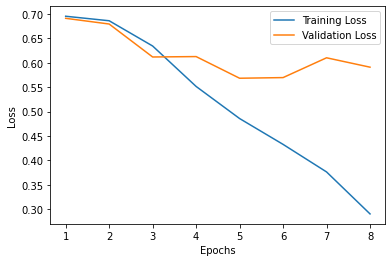

In [9]:
import matplotlib.pyplot as plt

# set the number of epochs
N_EPOCHS = 8

# compile the model
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# save the history of the model for evaluation
history = model_cnn.fit(X_train_tf, y_train_tf, epochs=N_EPOCHS, validation_data=(X_test_tf, y_test_tf), shuffle=True, batch_size=128)

# plot training and validation loss
epochs = range(1, N_EPOCHS+1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

We see that both training and validation loss decrease until the 5th epoch, but after that validation loss does not improve.

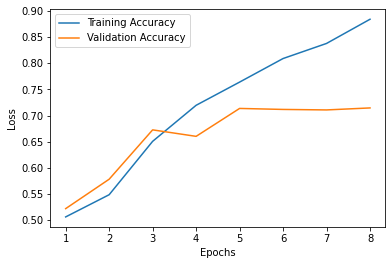

F1-score on the test set: 0.7249310027598896


In [10]:
# plot training and validation accuracy
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

from sklearn.metrics import f1_score

# calculate accuracy on the test dataset
y_pred = [np.argmax(out) for out in model_cnn.predict(X_test_tf)]
print("F1-score on the test set: %s" %f1_score(y_test_tf, y_pred))


We get an F1-score of 0.72 on the test dataset, which is lower than the baseline set by the Naive Bayes classifier.

##6. Data augmentation

In computer vision and speech recognition, data augmentation is commonly use to train more robust models when using smaller datasets. Data augmentation is less common in NLP because it is more challenging to come out with proper data augmentation techniques. 

[Wei and Zou (2019)](https://arxiv.org/pdf/1901.11196.pdf?ref=https://githubhelp.com) propose several methods for performing data augmentation. Here we experiment with one of them: adding to the training data shuffled versions of the input sentences. 

The following lines augment the dataset with four replicas for each tweet, with its word order shuffled.

In [11]:
import random

augmented_labels, augmented_sentences = [], []

# this parameter defines the amount of replicas to add to the training dataset
n = 4

# This function adds n replicas of the tweets set with shuffled sentences
for i in range(n):
    for label, sentence in zip(y_train, X_train):
      augmented_labels.append(label)
      new_sentence = sentence.split()
      random.shuffle(new_sentence)
      augmented_sentences.append(' '.join(new_sentence))

y_train_aug, X_train_aug = y_train + augmented_labels, X_train + augmented_sentences

Then, we transform the new dataset in tensors for training the CNN.

In [12]:
# fit a character-tokenizer on the texts
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=SIZE, char_level=True, oov_token=0)
tokenizer.fit_on_texts(X_train_aug)

# transform the training set in a sequence of numbers, add padding, and transform it into one-hot encoding representation
X_train_tf_aug = tokenizer.texts_to_sequences(X_train_aug)
X_train_tf_aug = tf.keras.preprocessing.sequence.pad_sequences(X_train_tf_aug, maxlen=160)
X_train_tf_aug = tf.keras.utils.to_categorical(X_train_tf_aug, num_classes=SIZE, dtype='d')

# create a one-hot encoding vector for the labels
y_train_tf_aug = np.array([label_list.index(label) for label in y_train_aug], dtype='d')

After we reset the weights of the CNN, we can re-train the model on the augmented dataset.

Epoch 1/8
164/164 [==============================] - 37s 225ms/step - loss: 0.5692 - accuracy: 0.6976 - val_loss: 0.4897 - val_accuracy: 0.7710
Epoch 2/8
164/164 [==============================] - 37s 224ms/step - loss: 0.4729 - accuracy: 0.7723 - val_loss: 0.4750 - val_accuracy: 0.7805
Epoch 3/8
164/164 [==============================] - 37s 223ms/step - loss: 0.3911 - accuracy: 0.8267 - val_loss: 0.5777 - val_accuracy: 0.7691
Epoch 4/8
164/164 [==============================] - 37s 223ms/step - loss: 0.3310 - accuracy: 0.8553 - val_loss: 0.4970 - val_accuracy: 0.8082
Epoch 5/8
164/164 [==============================] - 37s 223ms/step - loss: 0.2587 - accuracy: 0.8961 - val_loss: 0.5031 - val_accuracy: 0.8073
Epoch 6/8
164/164 [==============================] - 36s 222ms/step - loss: 0.1910 - accuracy: 0.9250 - val_loss: 0.6779 - val_accuracy: 0.7805
Epoch 7/8
164/164 [==============================] - 36s 222ms/step - loss: 0.1605 - accuracy: 0.9366 - val_loss: 0.6998 - val_accuracy:

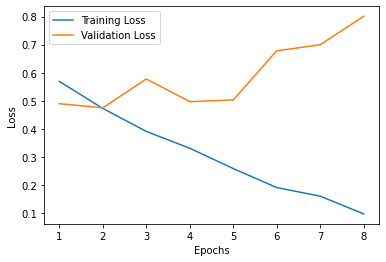

In [13]:
# compile the model
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# save the history of the model for evaluation
history = model_cnn.fit(X_train_tf_aug, y_train_tf_aug, epochs=N_EPOCHS, validation_data=(X_test_tf, y_test_tf), shuffle=True, batch_size=128)

# plot training and validation loss
epochs = range(1, N_EPOCHS+1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Here we see validation loss being quite constant after the first epoch (≈0.5), and actually increasing after the 5th epoch, but interestingly it is slightly lower than the validation loss we had in the previous experiment (≈0.6), which predicts an improvement in accuracy.

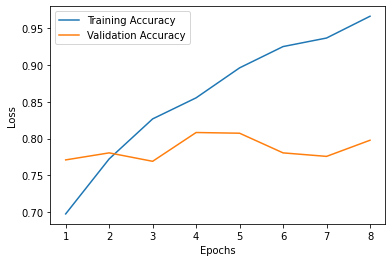

F1-score on the test set: 0.8117229129662523


In [14]:
# plot training and validation accuracy
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# calculate accuracy on the test dataset
y_pred_aug = [np.argmax(out) for out in model_cnn.predict(X_test_tf)]
print("F1-score on the test set: %s" %f1_score(y_test_tf, y_pred_aug))

In fact, the augmented dataset improves performance to approximately F1=0.81, which is in line with the Naive Bayes classifier performance. 

How is it possible??

The Naive Bayes classifier is trained on a set of 41K n-grams, while the CNN layer uses only 256 filters over character sequences of length 3 (essentially, trigrams). 

Re-training the Naive Bayes classifier on trigrams alone, even if we use all of them, would not match the performance of the CNN.


In [15]:
#vectorize the training data
vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(3,3))
X_train_NB = vectorizer.fit_transform(X_train)

print('Matrix calculated. Training data: ')
print('Rows x: %s' %X_train_NB.shape[0])
print('Columns x: %s' %X_train_NB.shape[1])
print('Labels y: %s' %len(y_train))

# Train a Naive Bayes classifier
model_nb = MultinomialNB()
model_nb.fit(X_train_NB, y_train)

print('Classifier trained.')

# Vectorize Evaluation
X_test_NB = vectorizer.transform(X_test)

print('Vectorization completed! Now predicting the labels....')

# Predict
ypred = model_nb.predict(X_test_NB)
accuracy = f1_score(y_test, ypred, average='macro')

# Calculate F-score globally
print('F1_score: %s' %accuracy)

Matrix calculated. Training data: 
Rows x: 4189
Columns x: 5256
Labels y: 4189
Classifier trained.
Vectorization completed! Now predicting the labels....
F1_score: 0.7662041315834762


Following this procedure, accuracy goes down to F1=0.77, which is quite inferior to the performance of the CNN.

#7. Why shuffled sentences improve the performance of the CNN?

Why is shuffling sentences helpful to improve the CNN performance? 

The result was unexpected, but I have a guess: data augmentation has the effect of moving attention of the network off of word boundaries, because while within-word trigrams stay the same after the words are shuffled, trigrams of the type X_Y, where we have a white space in the middle, change. This might be beneficial to avoid overfitting, because we expect these sequences to not be informative when learning morphological patterns and words.

#8. Conclusions

CNNs have been extremely successful in computer vision tasks. Here we see that they reach state-of-the-art performance at language identification as well (even though, so far, the results are comparable to those of shallow models). 

#9. EXTRAS: Training a vanilla Feedforward Neural Network for the task

To get the best of the two worlds, we can combine the two approaches by training a simple feed forward neural network: we can use character n-grams as features, and simply add nonlinearity.

In [16]:
# we define the size of the ngram vocabulary
SIZE = 10000

# here we vectorize the training and test datasets
vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(2,5), max_features=SIZE)
X_train_tf = vectorizer.fit_transform(X_train).todense()
X_test_tf = vectorizer.transform(X_test).todense()

y_train_tf = np.array([label_list.index(label) for label in y_train], dtype='d')
y_test_tf = np.array([label_list.index(label) for label in y_test], dtype='d')


The vanilla network that we use has:

1. A fully connected layer with 50 hidden units.

2. An output layer.

To regularize the network, neurons have a dropout rate of 0.5.

<center><img src="https://i.postimg.cc/RZrwZ8q5/vanilla.png" width='200' height='170' align="center"/></center>


In [17]:
# this is the vanilla network
model_dnn = tf.keras.Sequential()
# it has just two dense layers
model_dnn.add(tf.keras.layers.Dense(units=50, name='fc_1', activation='relu'))
model_dnn.add(tf.keras.layers.Dropout(rate=0.5))
model_dnn.add(tf.keras.layers.Dense(units=2, name='linear'))

model_dnn.build(input_shape=(None,SIZE))

model_dnn.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc_1 (Dense)                (None, 50)                500050    
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 linear (Dense)              (None, 2)                 102       
                                                                 
Total params: 500,152
Trainable params: 500,152
Non-trainable params: 0
_________________________________________________________________


Epoch 1/8
33/33 [==============================] - 1s 16ms/step - loss: 0.5779 - accuracy: 0.6930 - val_loss: 0.4907 - val_accuracy: 0.7681
Epoch 2/8
33/33 [==============================] - 0s 12ms/step - loss: 0.3943 - accuracy: 0.8262 - val_loss: 0.4585 - val_accuracy: 0.7586
Epoch 3/8
33/33 [==============================] - 0s 12ms/step - loss: 0.3070 - accuracy: 0.8771 - val_loss: 0.4178 - val_accuracy: 0.7987
Epoch 4/8
33/33 [==============================] - 0s 12ms/step - loss: 0.2406 - accuracy: 0.9102 - val_loss: 0.4211 - val_accuracy: 0.8053
Epoch 5/8
33/33 [==============================] - 0s 13ms/step - loss: 0.1965 - accuracy: 0.9260 - val_loss: 0.4243 - val_accuracy: 0.8073
Epoch 6/8
33/33 [==============================] - 0s 12ms/step - loss: 0.1562 - accuracy: 0.9470 - val_loss: 0.4303 - val_accuracy: 0.8139
Epoch 7/8
33/33 [==============================] - 0s 13ms/step - loss: 0.1228 - accuracy: 0.9659 - val_loss: 0.4587 - val_accuracy: 0.8025
Epoch 8/8
33/33 [===

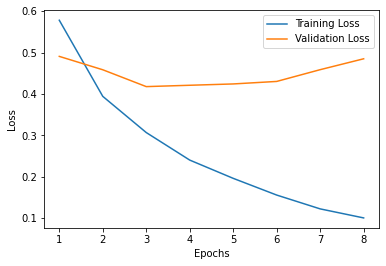

In [18]:
# compile the model
model_dnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# save the history of the model for evaluation
history = model_dnn.fit(X_train_tf, y_train_tf, epochs=N_EPOCHS, validation_data=(X_test_tf, y_test_tf), shuffle=True, batch_size=128)

#plot loss
epochs = range(1, N_EPOCHS+1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

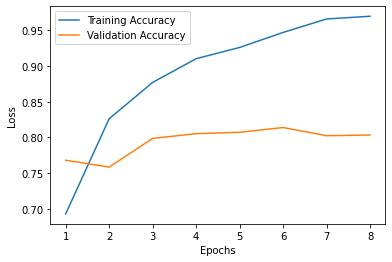

F1-score on the test set: 0.8026819923371648


In [19]:
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

y_pred = [np.argmax(out) for out in model_dnn.predict(X_test_tf)]
print("F1-score on the test set: %s" %f1_score(y_test_tf, y_pred))

As expected, we obtain a similar accuracy (F1-score: 0.81), but the network is much simpler!